In [1]:
from warnings import filterwarnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import LabelEncoder

from factor_analysis import FactorAnalysis
from factor_analysis.plotting import scree_plot, plot_loadings_heatmap, plot_corr_heatmap
from factor_analyzer.factor_analyzer import calculate_kmo

filterwarnings("ignore")
np.set_printoptions(suppress=True, precision=8)

# Anwendungsbeispiel: California Housing Data (1990)

Dieser Datensatz wurde von [Kaggle, California Housing Data](https://www.kaggle.com/harrywang/housing) übernommen und wird auch in diesem Buch als Beispieldatensatz benutzt:
[Handson ML](https://github.com/ageron/handson-ml2)

In diesem Datensatz wurden 207 Werte zufällig entfernt und eine kategorische Variable eingeführt
(ocean_proximity), welche grob die Nähe zum Meer angibt.

In der Datensatzbeschreibung heißt es:
> This dataset appeared in a 1997 paper titled Sparse Spatial Autoregressions by Pace, R. Kelley and Ronald Barry, published in the Statistics and Probability Letters journal.
> They built it using the 1990 California census data.
>
> It contains one row per census block group. A block group is the smallest geographical unit for which the U.S. Census Bureau publishes sample data
> (a block group typically has a population of 600 to 3,000 people).

Das bedeutet, dass jede Beobachtung eine sogenannte 'block group' (https://www.census.gov/programs-surveys/geography/about/glossary.html#par_textimage_4) angibt. Eine 'Block-Gruppe'
ist eine statistische Aufteilung von Volkszählungsgebieten des statistischen Bundesamts der USA.

Anstelle von Block-Gruppe werden wir hier meistens eher den intuitiveren Begriff Bezirk oder Gegend benutzen.


## Beschreibung der Daten

In [2]:
df = pd.read_csv("./data/housing.csv", header=0, sep=",")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Wir können sehen, dass alle Spalten numerische Merkmale sind, außer der letzten Spalte. Diese
ist das oben erwähnte kategorische Merkmal 'ocean_proximity', d.h. die Nähe zum Meer.

Insgesamt haben wir 20640 Beobachtungen (Bezirke) und 9 metrisch skalierte Merkmale haben. In der Spalte
'total_bedrooms' sind jedoch nur 20433 vorhandene Werte, d.h. 207 Werte fehlen.

In [3]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Für die Faktoranalyse benötigen wir jedoch ausschließlich metrisch skalierte Merkmale, weshalb wir
das kategorische Merkmal später entfernen. Für die Beschreibung des Datensatz könnte es allerdings
noch interessant sein.

Es fällt außerdem auf, das das Merkmal 'median_income' mit einer Mittelwert von 3.87 eine angepasste Skala haben muss. Es kann also nicht direkt als Einkommen interpretiert werden.

### Fehlende Werte
Bevor wir uns die Verteilung der Daten anschauen, untersuchen wir den Datensatz noch auf
fehlende Werte.
Oben haben wir bereits gesehen, dass es fehlende Werte in der Spalte 'total_bedrooms' gibt.

Die folgende Tabelle zeigt einige Statistiken bedingt darauf, dass der Wert in dieser Spalte fehlt.

In [5]:
df[df["total_bedrooms"].isna()].describe().iloc[1:3, :]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
mean,-119.472560,35.497633,29.270531,2562.603865,NaN,1477.772947,510.024155,3.822244,206007.280193
std,2.001424,2.097298,11.964927,1787.269789,NaN,1057.448212,386.120704,1.955595,111638.214545


Und hier sieht man die Statistiken, für den Fall, dass der Wert *nicht* fehlt.

In [6]:
df[df["total_bedrooms"].notna()].describe().iloc[1:3,:]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
mean,-119.570689,35.633221,28.633094,2636.504233,537.870553,1424.946949,499.433465,3.871162,206864.413155
std,2.003578,2.136348,12.591805,2185.269567,421.385070,1133.208490,382.299226,1.899291,115435.667099


Die Durchschnitte und Standardabweichungen sind ungefähr identisch, weswegen man hier auf den ersten Blick wohl
keinen Grund für das Fehlen der Werte erkennen kann.

Da anteilig nur sehr wenige Werte fehlen (siehe unten), habe ich mich dafür entschieden, die Beobachtungen mit fehlenden Werten zu entfernen.

In [7]:
print(f"Anteil fehlender Werte im Merkmal 'total_bedrooms': {df.total_bedrooms.isna().sum() / df.shape[0]:.2%}")

Anteil fehlender Werte im Merkmal 'total_bedrooms': 1.00%


In [8]:
X = df.dropna()

### Die Verteilung der Daten

Nun schauen wir uns einige univariate und bivariate Plots der metrischen Merkmale an, um ein Gefühl für die Daten zu bekommen.

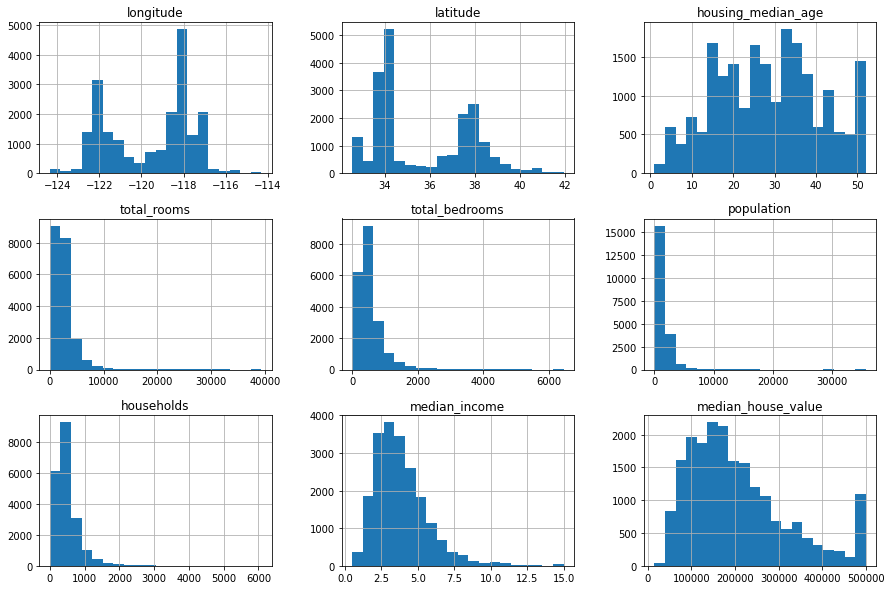

In [9]:
X.hist(figsize=(15, 10), bins=20)
plt.show()

In [ ]:
sns.pairplot(X, hue="ocean_proximity")

In diesem Pairplot sind univariate Plots auf der Hauptdiagonalen und bivariate Plots auf den nicht-diagonalen Elementen. Diese sind in Abhängigkeit
des kategorischen Merkmals 'ocean_proximity' angegeben.
Es fällt auf, dass die Merkmale total_rooms, total_bedrooms, population und households hoch miteinander korrelieren. Dies ist jedoch
unter Beachtung der Bedeutung der Merkmale nicht überraschend, da eine hohe Anzahl an Menschen im Bezirk schließlich bedeuten muss, dass mehr
Räume existieren und insgesamt die Zahl der Haushälte wohl höher sein muss. Des Weiteren sind sieht man, dass alle vier Merkmale eine relativ
hohe Schiefe aufweisen. Dies deutet auf Ausreißer hin, wie man auch an den Scatter-Plots sehen kann (viele Ausreißer sind unter 1h vom Meer entfernt).

Um die Schiefe der Verteilungen etwas zu reduzieren, versuchen wir mithilfe von Local Outlier Factor (LOF) einige Datenpunkte als Ausreißer zu klassifizieren.

In [ ]:
labels = LocalOutlierFactor(n_neighbors=35).fit_predict(X.drop(columns="ocean_proximity"))
outliers = X[labels == -1]
print(f"Number of outliers detected by LOF: {outliers.shape[0]}")

In [ ]:
X = X[labels == 1]
sns.pairplot(X, hue="ocean_proximity")
plt.show()

Wie man sehen kann, haben die Daten immer noch eine relativ hohe Schiefe, dies ist allerdings für unsere weitere Analyse nicht der Fokus.

Für den Rest der Analyse, werden wir das kategorische Merkmal entfernen.

In [ ]:
X.drop(columns="ocean_proximity", inplace=True)

# Faktoranalyse Schritt 1: Geeignetheit der Daten untersuchen

Bevor wir mit der eigentlichen Faktoranalyse starten, müssen wir die Geeignetheit der Daten überprüfen.
Dafür benutzen wir das Kaiser-Meyer-Olkin-Kriterium (KMO-Kriterium) für den kompletten Datensatz und das
dazu verwandte Measure of sampling adequacy (MSA) für jedes einzelne Merkmal.

Generell wollen wir, dass der KMO-Wert über 0.5 ist und der MSA-Wert für jede Variable ebenfalls 0.5 nicht
unterschreitet.

In [ ]:
msa_values, kmo = calculate_kmo(X)
print(f"The KMO-Criterion has a value of {kmo:.4f}\n")
msa_df = pd.DataFrame(msa_values.reshape(-1, 1), index=X.columns, columns=["MSA"])
print(msa_df)

Der KMO-Wert ist über 0.6, was auf eine akzeptable Qualität hinweist. Dies ist jedoch kein idealer Wert.
Außerdem ist der MSA-Wert für 4 Variablen unter 0.5, jedoch ist der Wert für die anderen Merkmale gut.

Jetzt könnte man beispielweise die Merkmale mit einem MSA-Wert unter 0.5 entfernen. Für dieses Beispiel
werden wir allerdings mit allen Variablen fortfahren.

Man sollte sich zudem noch die Korrelationsmatrix direkt anschauen. Dies tun wir im Folgenden mit einer
Heatmap, da sie sich sehr gut als visuelle Repräsentation eignet.

In [ ]:
plt.figure(figsize=(10, 10))
plot_corr_heatmap(X)#, file="./plots/california_housing_heatmap.png")

Hier sieht man, wie es mehrere Gruppen von hoch korrelierten Merkmalen gibt. Wie wir schon im Pairplot gesehen haben,
sind das die vier Merkmale in der Mitte, sowie housing_median_age mit einer leicht negativen Korrelation zu diesen vier Merkmalen.

Ebenso ist Longitude und Latitude negativ korreliert. Die Merkmale median_income und meidian_house_value sind positiv miteinander korreliert.
Dies deutet schon darauf hin, dass eine 3-Faktorlösung wahrscheinlich eine gute Wahl von k sein könnte. Im folgenden werden dies genauer betrachten.

# Faktoranalyse Schritt 2: Wahl der Faktorzahl $k$

Um diese Frage zu beantworten, werden wir zunächst alle Faktoren mit der Hauptkomponentenmethode (Principal Component, PC)
extrahieren und die Eigenwerte der Faktoren mithilfe eines 'Scree Plots' betrachten.

Dann können wir die Faktoren behalten, die einen Eigenwert größer Eins (Kaiser-Kriterium) haben, oder anhand eines 'Knicks'
im Plot eine geeignete Faktorzahl erkennen.

In [ ]:
fa = FactorAnalysis(n_factors=X.shape[1], method="pc").fit(X)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))
scree_plot(fa.eigenvalues_, ax)
#plt.savefig("./plots/california_housing_scree_plot.png")
plt.show()

Hier können wir sehen, dass die ersten drei Faktoren einen Eigenwert
größer als Eins haben. Dies macht im Hinblick auf die Korrelationsmatrix,
die wir vorhin gesehen haben, wegen den drei 'Boxen' auch Sinn. Nach
dem Kaiser-Kriterium sollten wir also ein 3-Faktor-Modell benutzen.

Der vierte Faktor ist jedoch nur minimal unter dem Eigenwert Eins, weshalb
man diesen auch nicht direkt ausschließen sollte. Ein 'Knick' wäre bei
$k = 5$ erkennbar.
Wir werden also $k \in [3, 4, 5]$ ausprobieren und den 'Besten' auswählen.

# Faktoranalyse Schritt 3: Extrahieren der Faktoren
Jetzt führen wir die eigentliche Faktorextraktion durch.

Dafür werden wir drei unterschiedliche Extraktionsmethoden miteinander vergleichen:
 - Hauptkomponentenmethode (engl. Principal Components Method (PC))
 - Hauptachsen-Faktorisierung (engl. Principal Axis Factoring (PAF))
 - Iterierte Hauptachsen-Faktorisierung (engl. Iterated Principal Axis Factoring (Iterated PAF))

Dabei ist die letzte Variante wohl die am Häufigsten eingesetzte Methode (unter diesen drei)

In [ ]:
methods = [
    ("PC", FactorAnalysis(method="pc")),
    ("Nicht-iterierte PAF", FactorAnalysis(method="paf", max_iter=1)),
    ("Iterierte PAF", FactorAnalysis(method="paf", max_iter=50)),
]
figsize = (15, 8)
for n_factors in range(3, 6):
    # this convenience method accepts unfitted factor analysis instances
    # and fits them for us. With the fa_params dict we can easily specify
    # the arguments which are shared across all instances.
    plot_loadings_heatmap(X, methods, figsize, fa_params={"n_factors": n_factors})#, file=f"./plots/cal_housing_loadings_with_{n_factors}_factors.png")

Hier sehen wir in jeder Zeile die Ladungsmatrizen der drei unterschiedlichen Methoden als Heatmap dargestellt.
Wir stellen fest, dass die 3-Faktorlösung tatsächlich im Hinblick auf eine einfache Struktur eine gute Lösung darstellt.
Die 4-Faktorlösung könnte jedoch auch noch eine valide Lösung sein. Lediglich die 5-Faktorlösung ist problematisch,
da kein Merkmal hoch (absoluter Wert größer 0.4) auf den fünften Faktor lädt.

Ein Problem ist jedoch, dass das Merkmal housing_median_age nur bei der PC-Methode sehr hoch auf den vierten Faktor lädt
und bei einer 3-Faktorlösung nur eine moderate Ladung auf den ersten Faktor hat.
Dies deutet auf eine hohe spezifische Varianz hin, d.h. die Faktoren sind nicht gut in der Lage, die Varianz des Merkmals
zu erklären.

Wir werden also die 3-Faktorlösung genauer betrachten.

In [ ]:
fa_params = {"n_factors": 3}

plot_loadings_heatmap(X, methods, figsize, fa_params=fa_params, annotate=True)

Wir können sehen, dass bei der PC-Methode die Ladungen generell höher ausfallen und dass der zweite Faktor ein unterschiedliches
Vorzeichen besitzt, im Gegensatz zu den anderen beiden Methoden.

Die iterierte und nicht-iterierte PAF-Methode sind sehr ähnlich zueinander. Jedoch ist die iterierte
Variante oft in Hinblick auf die reproduzierte Korrelationsmatrix besser. Dies können wir anhand des
RMSE untersuchen:

In [ ]:
for method, fa in methods:
    print(f"RMSE von {method}: {fa.get_rmse():.4f}")

Der root mean squared error of residuals (RMSE) ist bei der iterierten PAF-Methode am geringsten, gefolgt von der nicht-iterativen Variante und der
Hauptkomponentenmethode.

Diesen Unterschied können wir auch noch grafisch analysieren:

In [ ]:
fig, axes = plt.subplots(ncols=3, figsize=(20, 6), sharey=True)
for ax, (method, fa) in zip(axes, methods):
    R = fa.corr_
    R_hat = fa.get_reprod_corr()
    abs_residuals = np.abs(R - R_hat)
    mask = np.triu(np.ones_like(R))
    ax.set_title(method)
    sns.heatmap(abs_residuals.round(2), cmap="BuGn", ax=ax, cbar=False, annot=True, square=True, mask=mask)
fig.suptitle("Residualsmatrizen von drei Extraktionsmethoden mit k=3")
#plt.savefig("./plots/cal_housing_residual_mtx_plot.png")
plt.show()

In [ ]:
#for i, (_, fa) in enumerate(methods):
#    with open(f"./plots/cal_housing_parameter_summary_{i}.txt", "a") as f:
#        fa.print_summary(file=f)
for _, fa in methods:
    fa.print_summary()

In der Zusammenfassung können wir neben den Ladungen auch die Kommunalitäten und spezifischen Varianzen betrachten.
Die Eigenwerte werden jedoch nur für PC-Methode angezeigt. Dies ist aufgrund des in der Seminararbeit angesprochenen
Problems der Indefinitheit der reduzierten Korrelationsmatrix $\mathbf{\widehat{R}}$, auf der die Eigenwertzerlegung
bei der PAF-Methode basiert. Daher können bei dieser Methode die Eigenwerte nicht sinnvoll als Anteil an erklärter Varianz interpretiert werden.

Wir können sehen, dass die spezifischen Varianzen von 'housing_median_age' mit einem Wert zwischen 0.83 und 0.90 (je nach Methode) sehr hoch ist.
Das bedeutet, dass die Faktoren die Varianz dieses Merkmals gemeinsam nicht besonders gut erklären können. Dies spiegelt sich ebenfalls in den
sehr geringen Ladungen auf die drei Faktoren wider.
Die spezifischen Varianzen bei den restlichen Merkmalen sind jedoch sehr niedrig,
was ein gutes Zeichen für die Qualität der Faktorlösung ist.

Alle Merkmale, bis auf des eben angesprochenen Merkmals können eindeutig einem Faktor durch jeweils die betraglich
größte Ladung zugeordnet werden. Dies ist nicht immer der Fall, sodass eine Faktorrotation für eine leichtere Interpretation
sorgen könnte. Hier ist jedoch auch ohne Rotation eine Interpretation gut möglich. Wir werden im nächsten Schritt trotzdem
beispielhaft die mit der Varimax-Methode rotierten Faktorladungen ansehen.

Bevor wir das tun, werden wir noch die verschiedenen initialen Schätzungen der Kommunalitäten in der (iterierten) PAF-Methode betrachten.

In [ ]:
paf_comparison_methods = [
    ("Nicht-iterierte PAF", FactorAnalysis(method="paf", max_iter=1)),
    ("PAF mit max_iter=3", FactorAnalysis(method="paf", max_iter=3)),
    ("Iterierte PAF", FactorAnalysis(method="paf", max_iter=50)),
]
figsize = (10, 6)
initial_communality_estimates = {
    "smc": "Quadrierte multiple Korrelationen (SMC)",
    "mac": "Maximale absolute Korrelationen (MAC)",
    "ones": "Einsen"
}
for init_comm in initial_communality_estimates:
    print(f"Initiale Schätzung: {initial_communality_estimates[init_comm]}")
    plot_loadings_heatmap(X, paf_comparison_methods, figsize, fa_params={"n_factors": 3, "initial_comm" : init_comm})
    #, file=f"./plots/cal_housing_loadings_with_{init_comm}_initial_communality.png")
    print(f"Iterierte PAF hat {paf_comparison_methods[2][1].n_iter_} Iterationen benötigt.")
    for method, fa in paf_comparison_methods:
        print(f"RMSE von {method}: {fa.get_rmse():.4f}")
    print("\n")

Wir können sehen, dass nur geringe Unterschiede zwischen den unterschiedlichen initialen Schätzungen
in den Ladungen feststellbar sind. Nur in der nicht-iterierten Variante der PAF-Methode können wir einige
Unterschiede, vor allem im zweiten Faktor feststellen. Beispielsweise hat der zweite Faktor ein unterschiedliches
Vorzeichen, jedoch nur wenn Einsen als Kommunalitätsschätzung benutzt werden.

Wir stellen fest, dass die iterierte Variante jedoch eine unterschiedliche Anzahl an Iterationen benötigt, bis
das Konvergenzkriterium erreicht wird. Am Langsamsten ist es mm Falle von Einsen (10 Iterationen) und am schnellsten ist es
bei den maximalen absoluten Korrelationen (MAC) (nur 3 Iterationen). Ist das Konvergenzkriterium erfüllt, sind die Ladungen jedoch
bei allen drei initialen Schätzungen weitestgehend identisch.

# Faktoranalyse Schritt 4: Faktorrotation und -interpretation
Jetzt rotieren wir die Ladungen mit der Varimax-Methode und versuchen, die Faktoren zu interpretieren.

In [ ]:
methods = [
    ("Iteriete PAF (unrotiert)", FactorAnalysis(method="paf", rotation=None)),
    ("Iterierte PAF (mit Varimax-Rotation)", FactorAnalysis(method="paf", rotation="varimax"))
]
fa_params = {"n_factors": 3}
plot_loadings_heatmap(X, methods, fa_params=fa_params)#, file="./plots/cal_housing_paf_loadings_unrotated_rotated}")

Wie schon vorhin erwähnt, können wir in diesem Datensatz nur einen geringen
Unterschied erkennen, da die Faktorextraktion auch ohne Rotation schon ein
sehr klares Ergebnis liefert. Man sieht jedoch, dass die geringeren Ladungen
besser auf die höheren Ladungen "verteilt" wurde. Dies sieht man zum Beispiel
in den letzten beiden Merkmalen: Auf der rechten Seite (rotiert) sind die Ladungen
der ersten beiden Faktor noch kleiner (nahe bei null), während es bei der unrotierten
Variante beim zweiten Faktor immerhin -0.15 und -0.16 sind.

### Interpretation

Müssten wir die Faktoren interpretieren, könnte man sagen, dass
- der erste Faktor die Größe des Bezirks wiederspigelt,
- der zweite Faktor den Standort des Bezirks berücksichtigt und
- der dritte Faktor den Wohlstand im Bezirk bezeichnet.

# Faktoranalyse Schritt 5: Die Faktorwerte bestimmen

Als letzten Schritt können wir noch einen Blick auf die geschätzten Faktorwerte
werfen. Wie hätte als der Bezirk $i$ die drei oben beschriebenen Faktoren bewertet?

Da die Daten standardisiert wurden, sind die Faktorwerte auch (fast) standardisiert.
Der Mittelwert liegt bei Null, jedoch ist die Varianz der Faktorwerte nicht exakt 1.
Daher geben die Faktorwerte an, wie weit weg vom Mittelwert ein bestimmter Faktorwert
$f_{ij}$ des $i$-ten Bezirks für Faktor $j$ liegt.
Die hier benutzte Methode zur Schätzung der Faktorwerte ist *Thompon's Regressionsmethode*
welche eine multivariate lineare Regression benutzt, um die Faktorwerte
zu schätzen.

In [ ]:
scores = FactorAnalysis(n_factors=3).fit_transform(X)
scores = pd.DataFrame(scores, columns=["Größe", "Standort", "Wohlstand"])
print(scores.shape)
scores.head()

Hätte also der erste Bezirk in diesem Datensatz nicht die 8 Merkmale bewertet, sondern stattdessen
je einen Wert für die drei Faktoren angegeben, so läge der erste Faktorwert etwas mehr als eine
Standardabweichung unter dem Mittelwert. Die anderen beiden Faktorwerte lägen über dem Mittelwert,
wobei der dritte Faktorwert mit 2.22 deutlich über dem Mittelwert liegt.

Dies sind jedoch keine exakten Standardabweichungen, da die Faktorwerte nicht exakt eine Varianz
von 1 aufweisen.

In [ ]:
scores.mean(axis=0)

In [ ]:
scores.std(axis=0) ** 2

Benutzt man jedoch die Hauptkomponentenmethode, so weisen die Faktorwerte eine
Standardabweichung von Eins auf.

In [ ]:
scores = FactorAnalysis(method="pc", n_factors=3).fit_transform(X)
scores.std(axis=0) ** 2